In [1]:
######################################################### Settings #########################################################
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import get_cmap
from joblib import Parallel, delayed
import os

# Matplotlib Einstellungen gemäß den LaTeX-Caption-Formatierungen
plt.rcParams.update({
    'text.usetex': True,              # Enable LaTeX for text rendering
    'text.latex.preamble': r'\usepackage{amsmath}',
    'font.family': 'serif',           # Use a serif font family
    'font.serif': 'Palatino',         # Set Palatino as the serif font
    'font.size': 20,                   # Font size for general text
    'axes.titlesize': 20,              # Font size for axis titles
    'axes.labelsize': 20,              # Font size for axis labels
    'xtick.labelsize': 20,             # Font size for x-axis tick labels
    'ytick.labelsize': 20,             # Font size for y-axis tick labels
    'legend.fontsize': 20,             # Font size for legends
    'figure.figsize': [8, 6],          # Size of the plot (width x height)
    'figure.autolayout': True,         # Automatic layout adjustment
    'savefig.format': 'svg',           # Default format for saving figures
    'figure.facecolor': 'none',        # Make the figure face color transparent
    'axes.facecolor': 'none',          # Make the axes face color transparent
    'savefig.transparent': True        # Save figures with transparent background
})

output_dir = r"C:\Users\leopold\OneDrive - UT Cloud\Uni\Semester_8\BA_mit_Git\BA_Latex\Figures_From_Python"
os.makedirs(output_dir, exist_ok=True)

########################################                 Define constants                   #############################################
fixed_lam = 1
fixed_gamma = 1
fixed_dist_ext = 0.1 * fixed_lam
k_a = 2 * np.pi / fixed_lam

In [2]:
######################################################### Functions #########################################################
def dipole_vector(phi):
    return np.array([np.cos(phi), np.sin(phi), 0])

def z_rotation(angle):
    return np.array([[np.cos(angle), -np.sin(angle), 0],
                     [np.sin(angle),  np.cos(angle), 0],
                     [0,              0,             1]])

def chain_positions(distance, N_atoms):
    Pos = np.zeros((N_atoms, 3))
    for i in range(N_atoms):
        Pos[i, 0] = i * distance
    return Pos

def topo_positions(distance_in, N_atoms):
    Pos = np.zeros((N_atoms, 3))
    r = distance_in / np.sqrt(3)
    Chain = chain_positions(fixed_dist_ext, N_atoms // 3) + [r, 0, 0]
    Pos[:N_atoms//3] = np.dot(Chain, z_rotation(np.pi).T)
    Pos = Pos[Pos[:, 0].argsort()]
    Pos[N_atoms//3:2*N_atoms//3] = np.dot(Chain, z_rotation(2 * np.pi / 6).T)
    Pos[2*N_atoms//3:] = np.dot(Chain, z_rotation(-2 * np.pi / 6).T)
    return Pos

def Green_tensor(r_a, r_b):
    r_ab = r_b - r_a
    abs_r_ab = np.linalg.norm(r_ab)
    kappa = k_a * abs_r_ab
    return (np.exp(1j * kappa) / (4 * np.pi * kappa ** 2 * abs_r_ab)
                    * ((kappa ** 2 + 1j * kappa - 1) * np.eye(3)
                       + (- kappa ** 2 - 3 * 1j * kappa + 3)
                       * np.outer(r_ab, r_ab) / (abs_r_ab ** 2)))

def Gamma_matrix(distance_in, dipoles, N_atoms):
    positions = topo_positions(distance_in, N_atoms)
    G_matrix = np.zeros((N_atoms, N_atoms), dtype=complex)
    for a in range(N_atoms):
        for b in range(N_atoms):
            r_a, r_b = positions[a], positions[b]
            G_matrix[a, b] = fixed_gamma
            if np.linalg.norm(r_b - r_a) > 1e-5:
                d_a, d_b = dipoles[a], dipoles[b]
                G_matrix[a, b] = np.imag((6 * np.pi * fixed_gamma / k_a * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b), d_b.T))))
    return G_matrix

def V_matrix(distance_in, dipoles, N_atoms):
    positions = topo_positions(distance_in, N_atoms)
    V_matrix = np.zeros((N_atoms, N_atoms), dtype=complex)
    for a in range(N_atoms):
        for b in range(N_atoms):
            r_a, r_b = positions[a], positions[b]
            V_matrix[a, b] = 0
            if np.linalg.norm(r_b - r_a) > 1e-5:
                d_a, d_b = dipoles[a], dipoles[b]
                V_matrix[a, b] = - np.real((3 * np.pi * fixed_gamma / k_a * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b), d_b.T))))
    return V_matrix

def H_eff(distance_in, dipoles):
    G = Gamma_matrix(distance_in, dipoles, N_atoms)
    V = V_matrix(distance_in, dipoles, N_atoms)
    # Generate connections based on the updated rules
    return Qobj(V) - 1j / 2 * Qobj(G)

def survival_probabilities(times, dipoles, distance_in, Psi_0, N_atoms):
    H = H_eff(distance_in, dipoles)
    coeffs_sq_mods  = np.zeros((len(times), N_atoms))
    P_surs  = np.zeros((len(times)))
    for t_idx, t in enumerate(times):
        U = (-1j * H * t).expm()
        Psi_t = (U * Psi_0).full().flatten()
        Probs = np.abs(Psi_t)**2
        coeffs_sq_mods[t_idx, :] = Probs
        P_surs[t_idx] = Probs.sum()
    return coeffs_sq_mods, P_surs

#
# Functions to find the best solution for angles and distances such that V13 = 0,...
#
def Get_V_triangle(distance_in, angle1, angle2, angle3):
    dipoles = [dipole_vector(angle1), dipole_vector(angle2), dipole_vector(angle3)]
    idx1 = N_atoms//3 - 1
    idx2 = N_atoms//3
    idx3 = 2 * N_atoms//3
    V = V_matrix(distance_in, dipoles, N_atoms)
    return V[idx1, idx2], V[idx2, idx3], V[idx1, idx3]

# Target function to minimize V13/V12 and V23/V12 for a given distance and common angle
def target_function(angles, distance_in):
    angle1, angle2, angle3 = angles
    V12, V23, V13 = Get_V_triangle(distance_in, angle1, angle2, angle3)
    # Avoid division by zero
    if np.abs(V12) > 1e-5:
        # Compute the ratios
        ratio_V13_V12 = np.abs(V13) / np.abs(V12)
        ratio_V23_V12 = np.abs(V23) / np.abs(V12)
        
        # We want to minimize both ratios, so we return their sum
        return ratio_V13_V12 + ratio_V23_V12
    else:
        # If V12 is too small, return a large value (penalty)
        return np.inf

# Function to optimize over angles for a fixed distance
def find_optimal_angles_for_distance(distance_in):
    # Initial guesses for the angles as a list of scalars
    initial_guess = [np.pi / 4, np.pi / 4, np.pi / 4]
    bounds = [(0, np.pi/2), (0, np.pi/2), (0, np.pi/2)]  # Bounds for each angle
    
    # Perform the optimization using scipy's minimize function
    result = minimize(target_function, initial_guess, args=(distance_in,), bounds=bounds)
    return result.x, result.fun  # Return optimized angles and the minimized value

fixed d_(ext): 0.1
minimized value: 1.468177521589823e-09
Corresponding distance: 0.13474747474747475
Corresponding optimal angle: [0.55987376 0.51716187 0.50828821] radians
V12: 3.20304314578092
V13: 1.709882901934634e-09
V23: 2.9927530453832674e-09
Second minimized value: 1.725658564524868e-09
Corresponding second distance: 0.15393939393939396
Corresponding second optimal angle: [0.57733672 0.50383233 0.50581046] radians
V12 (second): 2.2579774494551326
V13 (second): 1.3719043401305697e-09
V23 (second): 2.524593784025697e-09


RuntimeError: latex was not able to process the following string:
b'd / d_ext'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.26 (MiKTeX 24.3.31) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(C:/Users/Leopold/.matplotlib/tex.cache/0c61aedf497a55346ec2e3dd70f0c407.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-03-14>
(C:\Users\Leopold\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(C:\Users\Leopold\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\Leopold\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\Leopold\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\mathpazo.sty)
(C:\Users\Leopold\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\Leopold\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\Leopold\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\Leopold\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\Leopold\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Users\Leopold\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\Leopold\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\Leopold\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg
))
(C:\Users\Leopold\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsmath.sty
For additional information on amsmath, use the `?' option.
(C:\Users\Leopold\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amstext.sty
(C:\Users\Leopold\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsgen.sty))
(C:\Users\Leopold\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsbsy.sty)
(C:\Users\Leopold\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsopn.sty))
(C:\Users\Leopold\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty)
(C:\Users\Leopold\AppData\Local\Programs\MiKTeX\tex/latex/psnfss\ot1ppl.fd)
(C:\Users\Leopold\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-d
vips.def)
No file 0c61aedf497a55346ec2e3dd70f0c407.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily d / d_
                      ext}
No pages of output.
Transcript written on 0c61aedf497a55346ec2e3dd70f0c407.log.




<Figure size 800x1000 with 4 Axes>

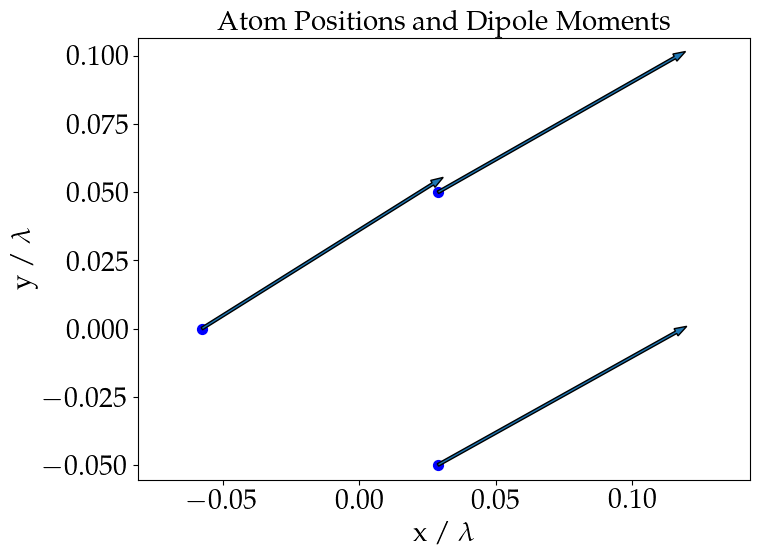

In [3]:
#
# Find the optimal values of d_in, theta that minimize V13, V23 and V12=/=0
#
N_atoms = 3
# Scanning over distances to find the best angle
num_distance_points = 100  # Number of distance points
distances = np.linspace(fixed_dist_ext / 10, 2 * fixed_dist_ext, num_distance_points) 

# Arrays to store results
optimal_angles = []
minimized_values = []
V12_values = []
V13_values = []
V23_values = []
ratio_V13_V12 = []
ratio_V23_V12 = []

for distance_in in distances:
    opt_angles, min_value = find_optimal_angles_for_distance(distance_in)
    optimal_angles.append(opt_angles)
    minimized_values.append(min_value)
    
    angle1, angle2, angle3 = opt_angles
    V12, V23, V31 = Get_V_triangle(distance_in, angle1, angle2, angle3)
    
    # Store the absolute values of the H_effian elements
    V12_values.append(np.abs(V12))
    V23_values.append(np.abs(V23))
    V13_values.append(np.abs(V31))
    
    # Compute the ratios if V12 is not too small (to avoid division by zero)
    if np.abs(V12) > 1e-5:
        ratio_V13_V12.append(np.abs(V31) / np.abs(V12))
        ratio_V23_V12.append(np.abs(V23) / np.abs(V12))
    else:
        ratio_V13_V12.append(np.nan)  # Append NaN for undefined ratios
        ratio_V23_V12.append(np.nan)
        
# Find the index of the minimum value in minimized_values
min_index = np.argmin(minimized_values[:])

# Get the corresponding distance and angle
minimized_value = minimized_values[min_index]
optimal_distance_in = distances[min_index]
optimal_angle_ = optimal_angles[min_index]
opt_V12_value = V12_values[min_index]
opt_V13_value = V13_values[min_index]
opt_V23_value = V23_values[min_index]

# Define the exclusion range (15 indices before and after the min_index)
exclusion_range = list(range(max(0, min_index - 5), min(len(minimized_values), min_index + 5)))

# Create a copy of minimized_values and set the values in the exclusion range to infinity
minimized_values_copy = np.array(minimized_values[:])
minimized_values_copy[exclusion_range] = np.inf

# Find the index of the second smallest value outside the exclusion range
second_min_index = np.argmin(minimized_values_copy)

# Get the corresponding distance and angle for the second smallest value
second_minimized_value = minimized_values[second_min_index]
second_optimal_distance_in = distances[second_min_index]
second_optimal_angle_ = optimal_angles[second_min_index]
second_opt_V12_value = V12_values[second_min_index]
second_opt_V13_value = V13_values[second_min_index]
second_opt_V23_value = V23_values[second_min_index]


# Print the results
print(f"fixed d_(ext): {fixed_dist_ext}")
print(f"minimized value: {minimized_value}")
print(f"Corresponding distance: {optimal_distance_in}")
print(f"Corresponding optimal angle: {optimal_angle_} radians")

print(f"V12: {opt_V12_value}")
print(f"V13: {opt_V13_value}")
print(f"V23: {opt_V23_value}")


# Print the results for the second minimum
print(f"Second minimized value: {second_minimized_value}")
print(f"Corresponding second distance: {second_optimal_distance_in}")
print(f"Corresponding second optimal angle: {second_optimal_angle_} radians")
print(f"V12 (second): {second_opt_V12_value}")
print(f"V13 (second): {second_opt_V13_value}")
print(f"V23 (second): {second_opt_V23_value}")

# Plot the minimized values with both the minimum and second minimum highlighted
fig, axs = plt.subplots(4, 1, figsize=(8, 10), sharex=True, constrained_layout=True)

# Plot for optimal angles
axs[0].plot(distances / fixed_dist_ext, optimal_angles, label='Optimal Angle', color='b')
axs[0].axvline(optimal_distance_in / fixed_dist_ext, color='r', linestyle='--', label='Minimized Distance')
axs[0].axvline(second_optimal_distance_in / fixed_dist_ext, color='g', linestyle='--', label='Second Minimized Distance')
axs[0].set_ylabel('Optimal Angle (radians)')
axs[0].grid(True)
axs[0].legend()

# Plot for minimized values
axs[1].plot(distances / fixed_dist_ext, minimized_values, label='Minimized Ratios', color='r')
axs[1].axvline(optimal_distance_in / fixed_dist_ext, color='r', linestyle='--', label='Minimized Value')
axs[1].axvline(second_optimal_distance_in / fixed_dist_ext, color='g', linestyle='--', label='Second Minimized Value')
axs[1].set_ylabel('Minimized Value (Ratios)')
axs[1].grid(True)
axs[1].legend()

# Plotting the Hamiltonian values
axs[2].plot(distances / fixed_dist_ext, V12_values, label='(V12)', color='b')
axs[2].plot(distances / fixed_dist_ext, V13_values, label='(V31)', color='r', linestyle='--')
axs[2].plot(distances / fixed_dist_ext, V23_values, label='(V23)', color='g', linestyle='--')
axs[2].axvline(optimal_distance_in / fixed_dist_ext, color='r', linestyle='--')
axs[2].axvline(second_optimal_distance_in / fixed_dist_ext, color='g', linestyle='--')
axs[2].set_ylabel('Hamiltonian Values')
axs[2].set_ylim([0, 0.1])
axs[2].grid(True)
axs[2].legend()

# Plotting the ratios of Hamiltonian values
axs[3].plot(distances / fixed_dist_ext, ratio_V13_V12, label='(V13 / V12)', color='r')
axs[3].plot(distances / fixed_dist_ext, ratio_V23_V12, label='(V23 / V12)', color='g')
axs[3].axvline(optimal_distance_in / fixed_dist_ext, color='r', linestyle='--')
axs[3].axvline(second_optimal_distance_in / fixed_dist_ext, color='g', linestyle='--')
axs[3].set_xlabel('d / d_ext')
#axs[3].set_ylabel('Ratios of Hamiltonian Values')
#axs[3].grid(True)
axs[3].legend()

# Show the combined figure
figure_name = f"TESTTtt.svg"
#plt.savefig(os.path.join(output_dir, figure_name))
plt.show()

# Plot atoms with their dipole moments in the seperate plot
positions = topo_positions(fixed_dist_ext, N_atoms)
dipoles = [dipole_vector(optimal_angle_[0]), dipole_vector(optimal_angle_[1]), dipole_vector(optimal_angle_[2])]
plt.figure()
plt.scatter(positions[:, 0], positions[:, 1], color='blue', s=50, label='Atoms')
for i in range(N_atoms):
    plt.arrow(positions[i, 0], positions[i, 1], 0.1*dipoles[i][0], 0.1*dipoles[i][1])
plt.title('Atom Positions and Dipole Moments')
plt.xlabel('x / $\lambda$')
plt.ylabel('y / $\lambda$')

# Save The figure
#figure_name = f"TOTALLY_SYMM_TOPO_Atom_Dipole_Pos_N={N_atoms}_angles=[{optimal_angle_[0]:.2f}, {optimal_angle_[1]:.2f}, {optimal_angle_[2]:.2f}]_dist_ext={fixed_dist_ext:.2f}_dist_in={optimal_distance_in}.svg"
#plt.savefig(os.path.join(output_dir, figure_name))
plt.axis('equal')
plt.show()

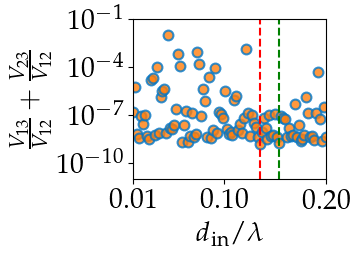

In [4]:
# Create figure with two vertically aligned subplots
fig, ax = plt.subplots(figsize=(4, 3))

ratio_V13_V12 = np.array(ratio_V13_V12)
ratio_V23_V12 = np.array(ratio_V23_V12)
# Lower plot: Ratios of Hamiltonian values (axs[1])
#ax.scatter(distances, ratio_V13_V12, label='(V13 / V12)', color='#1f77b4', s=30, marker='o', alpha=0.8, edgecolor='#0177C9', linewidth=1.5)
#ax.scatter(distances, ratio_V23_V12, label='(V23 / V12)', color='#ff7f0e', s=30, marker='o', alpha=0.8, edgecolor='#FF7F02', linewidth=1.5)
ax.scatter(distances, ratio_V13_V12 + ratio_V23_V12, color='#ff7f0e', s=50, marker='o', alpha=0.8, edgecolor='#0177C9', linewidth=1.5)
ax.axvline(optimal_distance_in, color='r', linestyle='--')
ax.axvline(second_optimal_distance_in, color='g', linestyle='--')

# Set limits and ticks for x and y axes on the second plot
x_min, x_max = distances.min(), distances.max()
y_max = max(np.max(ratio_V13_V12), np.max(ratio_V23_V12))
ax.set_yscale('log')
ax.set_xlim(0.01, x_max)
ax.set_ylim(1e-11, 0.1)

# Set custom ticks
ax.set_xticks([0.01, 0.1, x_max])
ax.set_yticks([1e-10, 1e-7, 1e-4, 0.1])

# Set labels and legend
ax.set_xlabel(r'$d_{\text{in}} / \lambda$')
ax.set_ylabel(r'$\frac{V_{13}}{V_{12}}+\frac{V_{23}}{V_{12}}$')
# Save the combined figure
figure_name = f"Ratios_SYMM.svg"
plt.savefig(os.path.join(output_dir, figure_name))

# Show the figure
plt.show()

In [63]:
# Define the threshold
threshold = 0.01

# Calculate the number of ratios below the threshold for each case
count_below_threshold_V13_V12 = sum(1 for ratio in ratio_V13_V12 if not np.isnan(ratio) and ratio < threshold)
count_below_threshold_V23_V12 = sum(1 for ratio in ratio_V23_V12 if not np.isnan(ratio) and ratio < threshold)

# Calculate the total number of valid ratios (excluding NaNs)
total_valid_V13_V12 = sum(1 for ratio in ratio_V13_V12 if not np.isnan(ratio))
total_valid_V23_V12 = sum(1 for ratio in ratio_V23_V12 if not np.isnan(ratio))

# Calculate the percentage of ratios below the threshold
percent_below_threshold_V13_V12 = (count_below_threshold_V13_V12 / total_valid_V13_V12) * 100 if total_valid_V13_V12 > 0 else 0
percent_below_threshold_V23_V12 = (count_below_threshold_V23_V12 / total_valid_V23_V12) * 100 if total_valid_V23_V12 > 0 else 0

# Print the results
print(f"Percentage of V13/V12 ratios below {threshold}: {percent_below_threshold_V13_V12:.2f}%")
print(f"Percentage of V23/V12 ratios below {threshold}: {percent_below_threshold_V23_V12:.2f}%")

In [6]:
#
# Probably its best to use  the same distance inside and outside
#
fixed_dist = 0.05
index_closest_to_fixed_dist = np.argmin(np.abs(distances - fixed_dist)) # find out the "right" spot #fixed_dist_ext
angle_at_fixed_dist = optimal_angles[index_closest_to_fixed_dist]
distance_in_at_fixed_dist = distances[index_closest_to_fixed_dist]
print(f"fixed_dist_ext: {fixed_dist_ext} -> not important for above, can be changed later!!")
print(f"look at distance: {fixed_dist}")
print(f"d_in at d_ext = fixed_dist: {distance_in_at_fixed_dist}")
print(f"Angle at d_ext = fixed_dist: {angle_at_fixed_dist}")

fixed_dist_ext: 0.1 -> not important for above, can be changed later!!
look at distance: 0.05
d_in at d_ext = fixed_dist: 0.05030303030303031
Angle at d_ext = fixed_dist: [0.38615464 0.67330342 0.51813791]
